In [114]:
# Assignment 3 Part B -- DTW and HMM

# CWRT DTW

In [115]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import subprocess

from collections import Counter
from sklearn import cluster

In [116]:
# Load Train and Dev MFCCs
# Structure of train_mfcc and dev_mfcc = {digit:{filename:np_array_of_MFCC}}
INF = 9999999
digits = [2,4,6,8,9]
train_mfcc = {}
dev_mfcc = {}

for dig in digits:
    train_path = f"./IsolatedDigits/{dig}/train/"
    dev_path = f"./IsolatedDigits/{dig}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    mfcc_fps = [fp for fp in train_fps if fp[len(fp)-4:len(fp)] == 'mfcc']
    train_mfcc[dig] = {}
    for fp in mfcc_fps:
        fn = fp.split('.')[0]
        train_mfcc[dig][fn] = np.loadtxt(train_path+fp, skiprows=1)
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    mfcc_fps = [fp for fp in dev_fps if fp[len(fp)-4:len(fp)] == 'mfcc']
    dev_mfcc[dig] = {}
    for fp in mfcc_fps:
        fn = fp.split('.')[0]
        dev_mfcc[dig][fn] = np.loadtxt(dev_path+fp, skiprows=1)

In [117]:
# TODO Remove
print(train_mfcc.keys(), train_mfcc[2].keys())

dict_keys([2, 4, 6, 8, 9]) dict_keys(['ac_2', 'ag_2', 'ai_2', 'an_2', 'bh_2', 'bi_2', 'br_2', 'ca_2', 'cg_2', 'cl_2', 'cm_2', 'dc_2', 'dg_2', 'ea_2', 'ec_2', 'ee_2', 'eg_2', 'ei_2', 'ek_2', 'es_2', 'hg_2', 'hp_2', 'ig_2', 'ih_2', 'il_2', 'jc_2', 'ji_2', 'jj_2', 'jn_2', 'jp_2', 'kc_2', 'kf_2', 'kh_2', 'kk_2', 'kn_2', 'kt_2', 'la_2', 'ld_2', 'ls_2'])


In [118]:
def cost(v1,v2,angle=False):
    '''
    Computes cost of difference between two vectors
    '''

    if not angle:
        return np.linalg.norm(v1-v2)
    else:
        diff = v2-v1
        # diff[np.where(diff>np.pi)] -= 2*np.pi
        # diff[np.where(diff<-np.pi)] += 2*np.pi
        if diff > np.pi:
            diff -= 2*np.pi 
        if diff < -np.pi:
            diff += 2*np.pi
        return np.abs(diff)

def dtw(x, y, angle=False):
    '''
    Computes DTW between sequences of MFCC vectors x and y 
    '''
    
    XLEN = len(x)
    YLEN = len(y)
    
    dp = [[INF for j in range(YLEN+1)] for i in range(XLEN+1)]
    dp[0][0] = 0

    for i in range(1,XLEN+1):
        for j in range(1,YLEN+1):
            cost_here = cost(x[i-1], y[j-1], angle)
            dp[i][j] = cost_here + min([dp[i-1][j], dp[i][j-1], dp[i-1][j-1]])
    
    return dp[-1][-1]

def majorityVoting(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

def dtwWithPath(x,y, angle=False):
    '''
    Same as dtw() but also return the warped form of y wrt x
    '''

    XLEN = len(x)
    YLEN = len(y)
    
    dp = [[[INF,i,j] for j in range(YLEN+1)] for i in range(XLEN+1)]
    dp[0][0] = [0,None,None]

    # Find DTW Matrix
    for i in range(1, XLEN+1):
        for j in range(1, YLEN+1):
            c = cost(x[i-1], y[j-1], angle)
            dp[i][j] = min([ [dp[i-1][j][0]+c, i-1, j], [dp[i][j-1][0]+c, i, j-1], [dp[i-1][j-1][0]+c, i-1, j-1]  ])

    # Extract Path
    curr = [XLEN, YLEN]
    path = [curr.copy()]
    dirs = []
    next = dp[curr[0]][curr[1]][1:]

    # ct = 0
    while next[0] != None and next[1] != None: 
        if next[0] < curr[0] and next[1] < curr[1]:
            dirs.append('J')
        elif next[1] < curr[1]:
            dirs.append('R')
        else:
            dirs.append('D')

        path.append(next.copy())
        curr = next.copy()
        next = dp[curr[0]][curr[1]][1:]

    path = path[::-1][1:]
    dirs = dirs[::-1][1:]
    
    # R : avg from curr to curr+runlength(R) inclusive
    # D : interp between curr and curr+runlength(D) inclusive, runlength(D) times

    # CWRT
    # Resolve all Rs first, they are avgs and their endpoints dont change
    # Then resolve Ds using the updated endpoints. Helps in case of ...DR...
    
    # Resolving Rs
    new_dirs = []
    warped_y = []
    R_run = 0
    D_run = 0
    ptr = 0
    for dir_ind in range(len(dirs)):
        dir = dirs[dir_ind]
        if dir == 'J':
            new_dirs.append('J')
            if R_run != 0:
                warped_y.append(np.mean(y[ptr-R_run:ptr+1], axis=0))
                R_run = 0
            elif D_run != 0:
                warped_y.append(y[ptr])
                D_run = 0
            else:
                warped_y.append(y[ptr])
            ptr+=1
        elif dir == 'R':
            R_run += 1
            ptr += 1
        else: # dir == 'D'
            D_run += 1
            new_dirs.append('D')
    if D_run != 0:
        warped_y.append(y[ptr])
        
    elif R_run != 0:
        warped_y.append(np.mean(y[ptr-R_run:ptr+1], axis=0))
    
    warped_y.append(y[-1])
    dirs = new_dirs.copy()

    # Resolving Ds
    y = warped_y.copy()
    warped_y = []
    D_run = 0
    ptr = 0
    for dir_ind in range(len(dirs)):
        dir = dirs[dir_ind]
        if dir == 'J':
            if D_run != 0:
                interps = np.linspace(y[ptr], y[ptr+1], D_run+2)[:-1]
                interps = [interps[ind] for ind in range(interps.shape[0])]
                warped_y.extend(interps)
                D_run = 0
                ptr+=1
            else:
                warped_y.append(y[ptr])
                ptr+=1
        else: # dir == 'D'
            D_run += 1
    if D_run != 0:
        interps = np.linspace(y[ptr], y[ptr+1], D_run+2)[:-1]
        interps = [interps[ind] for ind in range(interps.shape[0])]
        warped_y.extend(interps)
        D_run = 0
    else:
        warped_y.append(y[-1])
    
    return dp[-1][-1], warped_y


In [119]:
test_arr1 = np.array([1,7,3,4,1,10,5,4,7,4])
test_arr2 = np.array([1,4,5,10,9,3,2,6,8,4])
print(cost(test_arr1[1],test_arr2[1]))
res = dtwWithPath(test_arr1, test_arr2)
print(f"warped y: {res[1]}")

3.0
warped y: [1, 4.0, 4.333333333333333, 4.666666666666667, 5, 9.5, 3, 2, 7.0, 4]


In [120]:
def getTemplates(train_mfcc, angle=False):
    '''
    Computes a reference template for each class using CWRT
    '''

    templ = {dig:None for dig in train_mfcc.keys()}
    for dig in train_mfcc.keys():
        
        dig_fns = sorted(train_mfcc[dig].keys())
        init_templ = train_mfcc[dig][dig_fns[0]]
        warped_collection = [init_templ]
        for fn in dig_fns[1:]:
            mfcc_here = train_mfcc[dig][fn]
            res = dtwWithPath(init_templ, mfcc_here, angle)
            warped_mfcc_here = res[1]
            
            warped_collection.append(warped_mfcc_here)
            
        # print('shapes:', [len(arr) for arr in warped_collection])
        new_templ = np.mean(np.array(warped_collection), axis=0)
        templ[dig] = new_templ
    
    return templ
            

In [121]:
# Warp kc of Nc train examples of class c to same audio, then average
templ = getTemplates(train_mfcc)
print("Templates Built")

Templates Built


In [122]:
# Compute DTW error, get majority votes of top K, get class

def predictCWRT(train_mfcc, dev_mfcc, angle=False):

    t1 = time.time()
    correct = 0
    total = 0
    for dev_dig in dev_mfcc.keys():
        for dev_fn in dev_mfcc[dev_dig].keys():
            dev_frames = dev_mfcc[dev_dig][dev_fn]
            print(f"Dev {dev_fn} prediction: ", end = '')
            
            dig_best = None
            err_best = INF
            errs = []
            for train_dig in train_mfcc.keys():
                template = templ[train_dig]
                err_here = dtw(template, dev_frames, angle)
                if err_here < err_best:
                    err_best = err_here
                    dig_best = train_dig
            
            print(dig_best)
            if dig_best == dev_dig:
                correct+=1
            else:
                print(f"Failed, true: {dev_dig}, pred: {dig_best}")
            
            total += 1
    
    t2 = time.time()
    acc = correct/total
    print(f"Acc: {acc}")
    print("Time taken: {:.4f} sec".format(t2-t1))

def predict(train_mfcc, dev_mfcc, angle=False):
    t1 = time.time()
    K = 5
    correct = 0
    total = 0
    for dev_dig in dev_mfcc.keys():
        for dev_fn in dev_mfcc[dev_dig].keys():
            dev_frames = dev_mfcc[dev_dig][dev_fn]
            print(f"Dev {dev_fn} prediction: ", end = '')
            
            dig_best = None
            err_best = INF
            errs = []
            for train_dig in train_mfcc.keys():
            
                for train_fn in train_mfcc[train_dig].keys():
                    
                    train_frames = train_mfcc[train_dig][train_fn]
                    err_here = dtw(train_frames, dev_frames, angle)
                    errs.append([err_here, train_dig])
            
            topK = sorted(errs)[:K]
            topK_digs = [val[1] for val in topK]
            dig_best = majorityVoting(topK_digs)
            
            print(dig_best)
            if dig_best == dev_dig:
                correct+=1
                print("Passed, votes:", topK_digs)
            else:
                print("Failed, votes:", topK_digs)
            total += 1
    
    t2 = time.time()
    acc = correct/total
    print(f"Acc: {acc}")
    print("Time taken: {:.4f} sec".format(t2-t1))


In [123]:
# predict(train_mfcc, dev_mfcc)
predictCWRT(train_mfcc, dev_mfcc)

Dev mk_2 prediction: 2
Dev mm_2 prediction: 2
Dev ms_2 prediction: 2
Dev mw_2 prediction: 2
Dev nc_2 prediction: 2
Dev ng_2 prediction: 2
Dev nh_2 prediction: 2
Dev pe_2 prediction: 2
Dev pk_2 prediction: 2
Dev pm_2 prediction: 2
Dev pp_2 prediction: 2
Dev ra_2 prediction: 2
Dev mk_4 prediction: 4
Dev mm_4 prediction: 4
Dev ms_4 prediction: 4
Dev mw_4 prediction: 4
Dev nc_4 prediction: 4
Dev ng_4 prediction: 4
Dev nh_4 prediction: 4
Dev pe_4 prediction: 4
Dev pk_4 prediction: 4
Dev pm_4 prediction: 4
Dev pp_4 prediction: 4
Dev ra_4 prediction: 4
Dev mk_6 prediction: 6
Dev mm_6 prediction: 6
Dev ms_6 prediction: 6
Dev mw_6 prediction: 6
Dev nc_6 prediction: 6
Dev ng_6 prediction: 6
Dev nh_6 prediction: 6
Dev pe_6 prediction: 6
Dev pk_6 prediction: 6
Dev pm_6 prediction: 6
Dev pp_6 prediction: 6
Dev ra_6 prediction: 6
Dev mk_8 prediction: 8
Dev mm_8 prediction: 8
Dev ms_8 prediction: 8
Dev mw_8 prediction: 8
Dev nc_8 prediction: 8
Dev ng_8 prediction: 8
Dev nh_8 prediction: 8
Dev pe_8 pr

In [124]:
# Online Handwritten Character Recognition

def loadHW(path, angle=False):
    f = open(path, 'r')
    data = f.readline().split()[1:]
    data = [float(v) for v in data]
    feats = []
    for i in range(int(len(data)/2)):
        feats.append(np.array([data[2*i], data[2*i + 1]]))
    
    if angle:
        vecs = np.diff(np.array(feats), axis=0)
        angles = np.arctan2(vecs[:,1], vecs[:,0])
        return angles
    else:
        return feats

In [125]:
letters = ['a', 'ai', 'bA', 'chA', 'dA']
hwr_angle = True

# Load Train and Dev MFCCs
# Structure of train_mfcc and dev_mfcc = {digit:{filename:np_array_of_MFCC}}

train_feats = {}
dev_feats = {}

for let in letters:
    train_path = f"./HandwritingData/{let}/train/"
    dev_path = f"./HandwritingData/{let}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    train_feats[let] = {}
    for fp in train_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(train_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        train_feats[let][fn] = feats_here
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    dev_feats[let] = {}
    for fp in dev_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(dev_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        dev_feats[let][fn] = feats_here
        # dev_feats[let][fn] = loadHW(dev_path+fp)

In [126]:
print(train_feats.keys())
print(train_feats['a'].keys())
print(train_feats['a']['1'])

print(dev_feats.keys())
print(dev_feats['a'].keys())

dict_keys(['a', 'ai', 'bA', 'chA', 'dA'])
dict_keys(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '8', '9'])
[[-1.40671696  0.13053907]
 [-1.3465118  -0.03851219]
 [-1.28631573 -0.03851219]
 [-1.16591451 -0.20758899]
 [-1.10570935 -0.20758899]
 [-1.04551328 -0.20758899]
 [-0.92511206 -0.20758899]
 [-0.80471083 -0.03851219]
 [-0.74450568  0.13053907]
 [-0.62410445  0.63774393]
 [-0.56390838  0.8067952 ]
 [-0.56390838  0.975872  ]
 [-0.56390838  1.31400006]
 [-0.62410445  1.31400006]
 [-0.74450568  1.48305133]
 [-0.80471083  1.48305133]
 [-0.8649069   1.48305133]
 [-0.98530813  1.48305133]
 [-0.98530813  1.31400006]
 [-1.10570935  1.14492326]
 

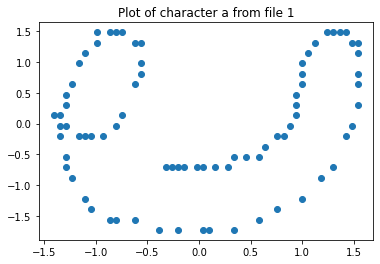

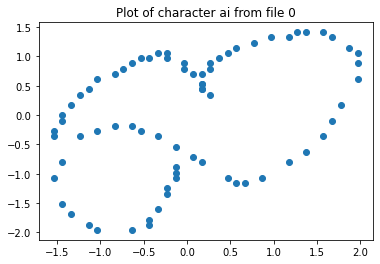

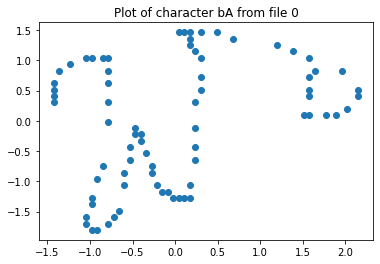

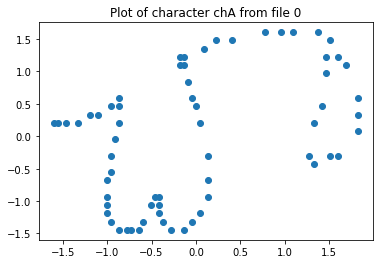

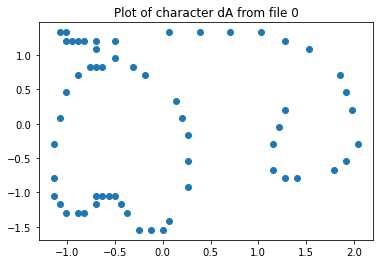

In [127]:
# Just exploring the data
if not hwr_angle:
    eg_ct = 1
    for let in train_feats.keys():
        for fn in list(train_feats[let].keys())[:eg_ct]:
            pts = train_feats[let][fn]
            x_pts = [v[0] for v in pts]
            y_pts = [v[1] for v in pts]

            plt.figure()
            plt.scatter(x_pts,y_pts)
            plt.title(f"Plot of character {let} from file {fn}")
            plt.show()

In [128]:
templ = getTemplates(train_feats, angle=hwr_angle)
print("Templates Built")

Templates Built


In [129]:
predictCWRT(train_feats, dev_feats, angle=hwr_angle)
# predict(train_feats, dev_feats, angle=hwr_angle)

# CWRT only angle, bad diff     --      98%
# Direct, only angle, bad diff  --      98%
# CWRT only angle, good diff    --      97%
# Direct only angle, good diff  --      99%
# CWRT, x,y mean,std normed     --      93%
# Direct, x,y mean,std normed   --      98%
# CWRT x,y                      --      73%
# Direct x,y                    --      82%

Dev 70 prediction: a
Dev 71 prediction: a
Dev 72 prediction: a
Dev 73 prediction: a
Dev 74 prediction: a
Dev 75 prediction: a
Dev 76 prediction: a
Dev 77 prediction: a
Dev 78 prediction: a
Dev 79 prediction: a
Dev 80 prediction: a
Dev 81 prediction: a
Dev 82 prediction: a
Dev 83 prediction: a
Dev 84 prediction: a
Dev 85 prediction: a
Dev 86 prediction: a
Dev 87 prediction: a
Dev 88 prediction: a
Dev 89 prediction: a
Dev 70 prediction: ai
Dev 71 prediction: ai
Dev 72 prediction: ai
Dev 73 prediction: ai
Dev 74 prediction: ai
Dev 75 prediction: ai
Dev 76 prediction: ai
Dev 77 prediction: ai
Dev 78 prediction: ai
Dev 79 prediction: ai
Dev 80 prediction: ai
Dev 81 prediction: ai
Dev 82 prediction: ai
Dev 83 prediction: ai
Dev 84 prediction: ai
Dev 85 prediction: ai
Dev 86 prediction: ai
Dev 87 prediction: ai
Dev 88 prediction: ai
Dev 89 prediction: ai
Dev 67 prediction: chA
Failed, true: bA, pred: chA
Dev 68 prediction: bA
Dev 69 prediction: bA
Dev 70 prediction: bA
Dev 71 prediction: bA
D

In [130]:
# Discrete HMM

# 1. Use vector quantization (k-means) to convert feature vecs to symbols
# 2. Store train and test symbol seqs in files
# 3. Use HMM C++ code to train on train seqs, build model
# 4. Use HMM C++ code to eval trained model on test seqs

In [172]:
# Vector Quantization using k-means

def k_means(data,k=15):
    # reshape data for numpy broadcasting
    data = np.reshape(data,[-1,1,data.shape[-1]])
    # initialize k means with random means
    myrange = np.linspace(0,data.shape[0]-1,k,dtype = np.int64)
    kmeans = np.vstack([data[myrange,0,i] for i in range(0,data.shape[-1])]).T
    # reshape data for numpy broadcasting
    kmeans = np.reshape(kmeans,[1,-1,kmeans.shape[-1]])
    # calculate distances
    dists = np.sum((data - kmeans)**2,axis=2)
    # initialize cluster assignments
    
    # choose n rows from a kxk identity matrix 
    # using an nx1 argmin matrix (ranging from 0 to k-1)
    # to produce an nxk 1-hot encoded matrix
    r_nk_old = np.eye(k)[np.argmin(dists,axis=1)]
    r_nk_new = r_nk_old.copy()
    c = 0
    while True:
        #print(f"Iteration {c}")
        c+=1
        # move cluster assignments into old variable for comparison
        r_nk_old = r_nk_new.copy()
        # update means
        if np.any(np.sum(r_nk_old,axis=0) == 0):
            print(r_nk_old)
            print("error, 0 sum encountered")
            break
        kmeans = (r_nk_old.T @ np.squeeze(data))/np.reshape(np.sum(r_nk_old,axis=0),[-1,1])
        # update new cluster assignments
        dists = np.sum((data - kmeans)**2,axis=2)
        r_nk_new = np.eye(k)[np.argmin(dists,axis=1)]
        # test for convergence
        if np.all(r_nk_old == r_nk_new):
            break
    print(f"Iterations to convergence = {c}")
    # print(f"r_nk shape: {r_nk_new.shape}")
    r_nk_int = np.argmax(r_nk_new, axis=1)
    return kmeans, r_nk_new, r_nk_int


def k_means_sklearn(feats, k=15):
    '''
    Performs k-means on elements of feats, returns cluster centres
    '''

    km_inst = cluster.KMeans(n_clusters=k, random_state=1)
    km_inst.fit(feats)
    return km_inst.cluster_centers_, km_inst.labels_

def quantize_with_means(feats, means):
    '''
    Quantizes each example, given k-means centres
    '''

    labels = {}
    for cl in feats.keys():
        labels[cl] = {}
        for fn in sorted(list(feats[cl].keys())):
            labels[cl][fn] = []
            feats_here = feats[cl][fn]
            if len(feats_here.shape) == 1:
                feats_here = np.reshape(feats_here, [-1,1])
            
            for feat in feats_here:
                min_norm = INF
                for m_id in range(len(means)):
                    # print("feat:", feat)
                    # print("means:", means)
                    norm_here = np.linalg.norm(feat-means[m_id])
                    if norm_here < min_norm:
                        min_norm = norm_here
                        feat_sym = m_id
                labels[cl][fn].append(feat_sym)
    return labels

def quantize_train(train_feats, k=15):
    '''
    Quantizes real valued vectors into symbols derived from k-means cluster centres
    '''

    # Take all vectors across files for particular class. Do k-means on that
    # For eg in handwriting, this means -- take one letter, do k-means on all instances of that letter
    
    means = None
    syms = {}
    all_feats = []
    tot = 0
    bd = {}
    cls = sorted(list(train_feats.keys()))
    for cl in cls:
        fns = sorted(list(train_feats[cl].keys()))
        if len(train_feats[cl][fns[0]].shape) == 1:
            class_feats = np.concatenate([np.reshape(train_feats[cl][fn], [-1,1]) for fn in fns])
        else:
            class_feats = np.concatenate([train_feats[cl][fn] for fn in fns])
        bounds = np.array([len(train_feats[cl][fn]) for fn in fns])
        bounds = [0] + list(np.cumsum(bounds))
        bd[cl] = {fns[i]:[bounds[i]+tot,bounds[i+1]+tot] for i in range(len(fns))}
        all_feats.append(class_feats)
        tot += len(class_feats)
    
    all_feats = np.concatenate(all_feats)
    # means, syms = k_means_sklearn(all_feats)
    means, syms_onehot, syms = k_means(all_feats, k)

    symd = {}
    for cl in train_feats.keys():
        symd[cl] = {}
        fns = sorted(list(train_feats[cl].keys()))
        for fn in fns:
            symd[cl][fn] = syms[bd[cl][fn][0]:bd[cl][fn][1]]
    
    return means, symd

def write_syms(symd, pref='dummy'):
    '''
    Write quantized symbols into seq file for HMM C++
    Set pref to 'train' or 'dev'
    '''

    try:
        os.mkdir(f'./HMM-Code/{pref}')
    except FileExistsError:
        pass
    
    for cl in symd.keys():
        out_str = ""
        for fn in symd[cl].keys():
            out_str += " ".join(str(char) for char in symd[cl][fn])
            out_str += "\n"

        with open(f'./HMM-Code/{pref}/{cl}.txt', 'w') as fo:
            fo.write(out_str)

In [173]:
letters = ['a', 'ai', 'bA', 'chA', 'dA']
hwr_angle = False

# Load Train and Dev Letters
# Structure of train_feats and dev_feats = {digit:{filename:np_array_of_feats}}

train_feats = {}
dev_feats = {}

for let in letters:
    train_path = f"./HandwritingData/{let}/train/"
    dev_path = f"./HandwritingData/{let}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    train_feats[let] = {}
    for fp in train_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(train_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        train_feats[let][fn] = feats_here
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    dev_feats[let] = {}
    for fp in dev_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(dev_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        dev_feats[let][fn] = feats_here

def generate_model_files():
    pass

In [175]:
# MFCC HMM
# K = 10
acc_vs_k = []
k_range = list(range(5,25))
for K in k_range:
    print(f"Starting K={K}")
    # Quantized
    means_train, syms_train = quantize_train(train_feats, K)
    # print(means_train)
    syms_dev = quantize_with_means(dev_feats, means_train)

    # Write symbols to sequences file for HMM C++
    write_syms(syms_train, 'hwr_train')
    write_syms(syms_dev, 'hwr_dev')

    # Set initial params for each class-specific HMM
    # Assume left-to-right HMM, and each state modelled by unimodal Gaussian
    # So num_states = num_symbols = k in k-means used earlier to cluster vectors 

    # home_pref = "/mnt/c/Users/nihal/Downloads/IITM/Academics/Sem"

    # Call HMM C++ trainer, get trained models for each class
    for cl in sorted(list(train_feats.keys())):

        sp = subprocess.run(["wsl", "cd", "HMM-Code;", "./train_hmm", f"./hwr_train/{cl}.txt", "1234", f"{K}", f"{K}", "0.01"], shell=True, capture_output=True)
        # print(sp.stdout.decode('utf-8'))
        # print("Errors:", sp.stderr.decode('utf-8'))

    # Test on dev seqs, get probabs from each HMM, predict with argmax
    preds = {}
    for dev_cl in sorted(list(dev_feats.keys())):
        dev_cl_fns = sorted(list(dev_feats[dev_cl].keys()))
        dev_cl_fns_ind = {dev_fn:dev_cl_fns.index(dev_fn) for dev_fn in dev_cl_fns}
        preds[dev_cl] = {dev_ex:{} for dev_ex in dev_cl_fns}
        for train_cl in train_feats.keys():
            sp = subprocess.run(["wsl", "cd", "HMM-Code;", "./test_hmm", f"./hwr_dev/{dev_cl}.txt", f"./hwr_train/{train_cl}.txt.hmm"], shell=True, capture_output=True)
            # print(sp.stdout.decode('utf-8'))
            out = sp.stdout.decode('utf-8')
            out_lst = out.split('\n')
            out_lst = [line for line in out_lst if line[:5]=='alpha']
            out_lst = [float(line.split(' ')[4]) for line in out_lst]
            # print(out_lst)
            for dev_ex in dev_cl_fns:
                preds[dev_cl][dev_ex][train_cl] = out_lst[dev_cl_fns_ind[dev_ex]]
            # print("Errors (if any):", sp.stderr.decode('utf-8'))
            # print("-----------------------------------------------")
    print("Probabs Generated")

    correct = 0
    total = 0
    for dev_cl in sorted(list(preds.keys())):
        for dev_fn in sorted(list(preds[dev_cl].keys())):
            probs_here = preds[dev_cl][dev_fn]
            pred_cl = max(probs_here, key=probs_here.get)
            if pred_cl == dev_cl:
                correct += 1
            total += 1
    acc = correct/total
    print(f"Acc: {acc}")
    acc_vs_k.append(acc)

Starting K=5
Iterations to convergence = 98
Probabs Generated
Acc: 0.83
Starting K=6
Iterations to convergence = 103
Probabs Generated
Acc: 0.91
Starting K=7
Iterations to convergence = 72
Probabs Generated
Acc: 0.95
Starting K=8
Iterations to convergence = 54
Probabs Generated
Acc: 0.91
Starting K=9
Iterations to convergence = 217
Probabs Generated
Acc: 0.94
Starting K=10
Iterations to convergence = 114
Probabs Generated
Acc: 0.92
Starting K=11
Iterations to convergence = 196
Probabs Generated
Acc: 0.87
Starting K=12
Iterations to convergence = 130
Probabs Generated
Acc: 0.92
Starting K=13
Iterations to convergence = 66
Probabs Generated
Acc: 0.94
Starting K=14
Iterations to convergence = 51
Probabs Generated
Acc: 0.98
Starting K=15
Iterations to convergence = 52
Probabs Generated
Acc: 0.91
Starting K=16
Iterations to convergence = 199
Probabs Generated
Acc: 0.87
Starting K=17
Iterations to convergence = 197
Probabs Generated
Acc: 0.99
Starting K=18
Iterations to convergence = 91
Prob

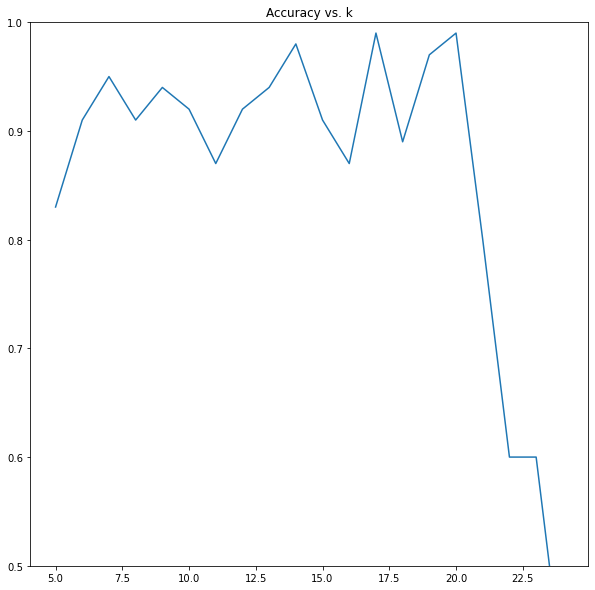

In [179]:
plt.figure(figsize=[10,10])
plt.plot(k_range, acc_vs_k)
plt.title("Accuracy vs. k")
plt.ylim(0.5,1.0)
plt.show()

In [ ]:
# TODOs

# TODO MFCC HMM
# TODO Connected Spoken Digits
# TODO Connected Handwritten Characters
# TODO ROC, DET, Confusion Matrices for all 4 + 2 optional tasks